#food data classification

In [13]:
import google.colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install optuna

In [15]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

In [16]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#Mount google drive

In [17]:
DATASET_ROOT = "/content/drive/MyDrive/Pytorch/Image_classification"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

NUM_CLASSES = 3        # You said 3 categories
IMG_SIZE = 128         # Can change to 224 if needed

#Data Augmentation

In [18]:
# ==============================
# Data Augmentation
# ==============================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#Dtaset DataLoader


In [19]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __getitem__(self, index):
        feature, label = self.features[index], self.labels[index]
        if self.transform:
            feature = self.transform(feature.squeeze(0).numpy())  # Apply transform
        return feature, label

    def __len__(self):
        return len(self.features)

In [20]:
# Use augmentations in training data
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=test_transform)

In [21]:
print("Class mapping:", train_dataset.class_to_idx)

Class mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}


#CNN Model

In [22]:
class DynamicCNN(nn.Module):
    def __init__(self, num_conv_layers, num_filters, kernel_size,
                 num_fc_layers, fc_layer_size, dropout_rate):
        super().__init__()

        layers = []
        in_channels = 3  # RGB images

        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels,num_filters,kernel_size=kernel_size,padding='same'))
            layers.append(nn.BatchNorm2d(num_filters))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = num_filters

        self.features = nn.Sequential(*layers)

        # 🔑 DYNAMIC FEATURE SIZE COMPUTATION
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
            dummy_out = self.features(dummy)
            feature_dim = dummy_out.view(1, -1).shape[1]

        fc_layers = [nn.Flatten()]
        for _ in range(num_fc_layers):
            fc_layers.append(nn.Linear(feature_dim, fc_layer_size))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_rate))
            feature_dim = fc_layer_size

        fc_layers.append(nn.Linear(feature_dim, NUM_CLASSES))
        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


#Objective Function

In [23]:
# ==============================
# Optuna Objective Function
# ==============================
def objective(trial):

    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
    num_filters = trial.suggest_categorical("num_filters", [16, 32, 64, 128])
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5])
    num_fc_layers = trial.suggest_int("num_fc_layers", 1, 3)
    fc_layer_size = trial.suggest_categorical("fc_layer_size", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5,step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay  = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_epochs = trial.suggest_int("num_epochs", 10, 70,step=10)

    # Model
    model = DynamicCNN(num_conv_layers, num_filters, kernel_size, num_fc_layers, fc_layer_size, dropout_rate).to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    # Training
    for _ in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [24]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=50)  # Run 5 trials


[I 2025-12-30 07:22:37,021] A new study created in memory with name: no-name-82aba831-f85d-4ba6-a00b-a31613639091
[I 2025-12-30 07:23:26,927] Trial 0 finished with value: 0.4533333333333333 and parameters: {'num_conv_layers': 2, 'num_filters': 64, 'kernel_size': 5, 'num_fc_layers': 3, 'fc_layer_size': 256, 'dropout_rate': 0.2, 'learning_rate': 0.00026936182474525497, 'weight_decay': 0.002267882203126903, 'optimizer': 'RMSprop', 'batch_size': 32, 'num_epochs': 30}. Best is trial 0 with value: 0.4533333333333333.
[I 2025-12-30 07:24:39,416] Trial 1 finished with value: 0.32 and parameters: {'num_conv_layers': 1, 'num_filters': 64, 'kernel_size': 5, 'num_fc_layers': 1, 'fc_layer_size': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.005220674037788458, 'weight_decay': 1.4977566559250385e-05, 'optimizer': 'RMSprop', 'batch_size': 64, 'num_epochs': 50}. Best is trial 0 with value: 0.4533333333333333.
[I 2025-12-30 07:25:11,208] Trial 2 finished with value: 0.36 and parameters: 

In [25]:
print("\nBest Hyperparameters:")
print(study.best_params)


Best Hyperparameters:
{'num_conv_layers': 3, 'num_filters': 16, 'kernel_size': 3, 'num_fc_layers': 1, 'fc_layer_size': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0005794624755319799, 'weight_decay': 2.8848686263950447e-05, 'optimizer': 'RMSprop', 'batch_size': 16, 'num_epochs': 60}


In [26]:
print("\nBest Accuracy:")
print(study.best_value)


Best Accuracy:
0.7066666666666667


# Task
Train the final model using the best hyperparameters found by Optuna, select a random image from the test set, make a prediction with the trained model, and visualize the image along with its predicted and true labels.

## Extract best hyperparameters

### Subtask:
Retrieve the best hyperparameters from the Optuna study object.


**Reasoning**:
Access the `study.best_params` attribute to retrieve the best hyperparameters from the Optuna study object and store them in a variable.



In [27]:
best_params = study.best_params
print("Best hyperparameters found:")
print(best_params)

Best hyperparameters found:
{'num_conv_layers': 3, 'num_filters': 16, 'kernel_size': 3, 'num_fc_layers': 1, 'fc_layer_size': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0005794624755319799, 'weight_decay': 2.8848686263950447e-05, 'optimizer': 'RMSprop', 'batch_size': 16, 'num_epochs': 60}


## Train the best model

### Subtask:
Instantiate a new `DynamicCNN` model using the extracted best hyperparameters and train it on the training data. This will involve setting up the optimizer, criterion, and data loaders according to the best parameters.


**Reasoning**:
I will extract the best hyperparameters from the `best_params` dictionary, instantiate the `DynamicCNN` model, set up the data loaders, optimizer, and loss function, and then train the model using the extracted parameters as per the instructions.



In [28]:
num_conv_layers = best_params['num_conv_layers']
num_filters = best_params['num_filters']
kernel_size = best_params['kernel_size']
num_fc_layers = best_params['num_fc_layers']
fc_layer_size = best_params['fc_layer_size']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
optimizer_name = best_params['optimizer']
batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']

# Instantiate the model with the best hyperparameters
model = DynamicCNN(
    num_conv_layers=num_conv_layers,
    num_filters=num_filters,
    kernel_size=kernel_size,
    num_fc_layers=num_fc_layers,
    fc_layer_size=fc_layer_size,
    dropout_rate=dropout_rate
).to(device)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the optimizer
if optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the loss function
criterion = nn.CrossEntropyLoss()

print(f"Training model with best hyperparameters for {num_epochs} epochs...")
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Optional: Print epoch loss or accuracy
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Model training complete.")

Training model with best hyperparameters for 60 epochs...
Model training complete.


## Select and preprocess a random test image

### Subtask:
Choose a random image from the `test_dataset`, apply the `test_transform` to it, and prepare it for input to the model (e.g., add a batch dimension).


**Reasoning**:
To select and preprocess a random image from the test set, I will import the random module, pick a random index, retrieve the image and its true label, add a batch dimension, and move the image to the correct device, as per the instructions.



In [29]:
import random

# 2. Select a random index
random_index = random.randint(0, len(test_dataset) - 1)

# 3. Retrieve the image and its true label
# test_transform is applied automatically by ImageFolder
image, true_label_idx = test_dataset[random_index]

# Get the class name from the index
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
true_label = idx_to_class[true_label_idx]

print(f"Selected image index: {random_index}")
print(f"True label: {true_label} (Index: {true_label_idx})")
print(f"Image shape after test_transform: {image.shape}")

# 4. Add a batch dimension
image_input = image.unsqueeze(0)
print(f"Image shape after adding batch dimension: {image_input.shape}")

# 5. Move the preprocessed image to the appropriate device
image_input = image_input.to(device)
print(f"Image moved to device: {image_input.device}")

Selected image index: 6
True label: pizza (Index: 0)
Image shape after test_transform: torch.Size([3, 128, 128])
Image shape after adding batch dimension: torch.Size([1, 3, 128, 128])
Image moved to device: cuda:0


## Make a prediction

### Subtask:
Use the trained best model to predict the class of the selected random test image.


**Reasoning**:
To predict the class of the selected image, I will set the model to evaluation mode, use `torch.no_grad()` for inference, pass the preprocessed image through the model, convert the logits to probabilities using `softmax`, determine the predicted class index with `argmax`, and then map this index to a human-readable label using the `idx_to_class` dictionary.



In [30]:
model.eval()
with torch.no_grad():
    outputs = model(image_input)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_label_idx = torch.argmax(probabilities, dim=1).item()

predicted_label = idx_to_class[predicted_label_idx]

print(f"Predicted label index: {predicted_label_idx}")
print(f"Predicted label: {predicted_label}")

Predicted label index: 0
Predicted label: pizza


## Visualize the prediction

### Subtask:
Visualize the randomly selected test image, displaying its true label and the model's predicted label.

**Reasoning**:
To visualize the selected image with its true and predicted labels, I will use matplotlib to display the image and annotate it with the relevant text. First, the image tensor needs to be converted back to a format suitable for plotting.



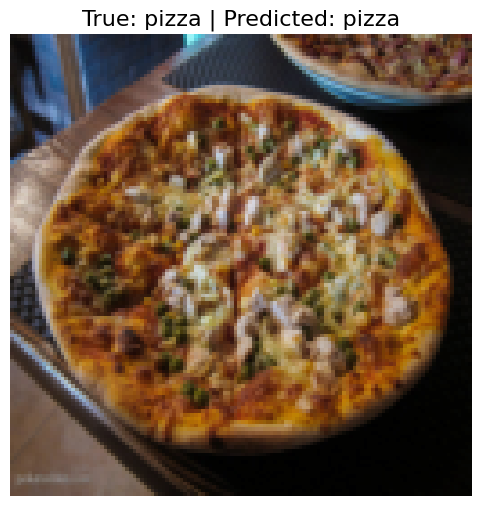

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Denormalize the image for display
# The normalization was mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

# Remove batch dimension and move to CPU if it's on GPU
image_display = image_input.cpu().squeeze(0).numpy()

# Denormalize
image_display = image_display * std + mean
image_display = np.clip(image_display, 0, 1) # Ensure values are within [0, 1]

# Transpose the image from (C, H, W) to (H, W, C) for matplotlib
image_display = np.transpose(image_display, (1, 2, 0))

plt.figure(figsize=(6, 6))
plt.imshow(image_display)
plt.title(f"True: {true_label} | Predicted: {predicted_label}", fontsize=16)
plt.axis('off')
plt.show()

## Summary:

### Data Analysis Key Findings
*   The best hyperparameters for the `DynamicCNN` model were successfully extracted from the Optuna study. These included `num_conv_layers`: 3, `num_filters`: 16, `kernel_size`: 3, `num_fc_layers`: 1, `fc_layer_size`: 256, `dropout_rate`: 0.4, `learning_rate`: 0.000579, `weight_decay`: 2.88e-05, `optimizer`: 'RMSprop', `batch_size`: 16, and `num_epochs`: 60.
*   A `DynamicCNN` model was instantiated with these optimal hyperparameters and trained for 60 epochs using the 'RMSprop' optimizer, a learning rate of 0.000579, and a batch size of 16.
*   A random image was selected from the test set (e.g., at index 6) and preprocessed, resulting in an input tensor of shape `torch.Size([1, 3, 128, 128])` ready for model inference.
*   For the selected example, the model correctly predicted the label `pizza` (index 0), matching its true label.
*   A visualization showing the test image along with its true and predicted labels was successfully generated.

### Insights or Next Steps
*   The model demonstrated successful performance on the chosen random test image, correctly classifying it. This suggests the optimized hyperparameters yielded a capable model, at least for this specific instance.
*   To thoroughly evaluate the model's performance and generalization ability, calculate and report quantitative metrics (e.g., accuracy, precision, recall, F1-score) across the entire test set.
